In [1]:
import numpy as np 
import pandas as pd 
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import bisect
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn")
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# good behavior for notebooks!
sns.set(context='notebook' , color_codes=True)
%matplotlib inline

# Finding Higgs Bosons!!

This notebook will serve as a building block for homework set four, in which you'll be exploring the use of Neural Networks (NNs) to study a represenative data sample from the search for the Higgs boson at the Large Hadron Collider (LHC).  In 2014, a machine learning challenge was posted to Kaggle to encourage data scientists across the world to try their hand(s) at searching for Higgs bosons in a simulated data sample.  The simulations were identical to the ones used by the ATLAS collaboration to search for Higgs bosons decaying to two tau leptons ($H \rightarrow \tau^+ \tau^-$).

Many people tried their best and after 6 months the contest ended.  Three winners were chosen by the contest judges and were awarded cash prizes, as well as an expense-paid trip to CERN:

1.  Gabor Melis : 7000 dollars
2.  Tim Salimans : 4000 dollars
3.  Pierre Courtiol (nhlx5haze) : 2000 dollars

You can find details about the challenge at the primary ATLAS site (https://higgsml.lal.in2p3.fr) and on Kaggle (https://www.kaggle.com/c/higgs-boson/).  The data sample consists of over 800k "events" that are a mixture of simulated $H \rightarrow \tau^+ \tau^-$ signal events with $M_{Higgs}=125$ GeV in addition to a range of non-Higgs "background" events (eg, $Z \rightarrow \tau^+ \tau^-$).  In this context, one event corresponds to a proton-proton collision at the LHC that was recorded by the ATLAS detector.  The signal-to-background ratio is roughly 0.0017, so the challenge is much like searching for a needle in a haystack! 

The data sample consists of 17 "primitive / PRI" features that correspond to the reconstructed observables in each event and 13 "derived / DER" features that are constructed from the primitive features using domain knowledge of the signal and background processes.  In addition, the are unique identifiers (Event ID) and sample weights that allow for converting from integer simulated events to the expected number of events to have been produced in the data sample.  A detailed description of the features is provided here (http://opendata.cern.ch/record/328) and in even more detail here (http://opendata.cern.ch/record/329).  You are not expected to spend time learning the details, so this is for your own interest.

The contestants were given the first 250k events with labels ("s" and "b") to allow for training of a supervised learning classifier.  In addition, a second sample of 250k events **without** labels was provided as a way of testing for overtraining.  A third sample of ~300k events was withheld by the contest organizers as a blind validation sample to rank the contestants.  The ranking was performed by evaluating a metric called the "Approximate Median Significance", wherein a larger value corresponds to a more significant observation of Higgs boson production.  The submissions at the top of the leaderboards had AMS scores around 3.80.

$AMS  = \sqrt{2\left( (s+b+10)\log\left(1+{s \over b+10}\right) -s \right)}$


Your challenge in homework set four will be to engage in the Higgs boson ML contest for yourself as a way to learn about NNs.  We will use this data set for class sessions on Feb 23, Feb 25 and Mar 4.  In this notebook, we will explore the use of the Multilayer Perceptron classifier offered by `scikit-learn`.  In the following class periods, we will explore the use of `PyTorch` and `Keras` as alternative NN frameworks.

# Load the data sample

The first thing to do here is load the data sample.  We will use the `pandas` `dataframe` class, as it's well suited to this task.  For the training sample, we will use the first 350k samples.  The remaining samples will be for validation and evaluation of independent AMS scores.

In [2]:
# read the first 350k samples
dataset=pd.read_csv('higgs-boson/atlas-higgs-challenge-2014-v2.csv',nrows=350000)

# summarize the data

# shape
print("Shape:\n",dataset.shape, "\n")

# first 20 samples
#print("Head:\n",dataset.head(20), "\n")

# descriptions
print("Description:\n",dataset.describe(), "\n")

# class distributio
print("Class Distribution:\n",dataset.groupby('Label').size())


Shape:
 (350000, 35) 

Description:
              EventId   DER_mass_MMC  DER_mass_transverse_met_lep  \
count  350000.000000  350000.000000                350000.000000   
mean   274999.500000     -49.134738                    49.276886   
std    101036.441445     406.403335                    35.401185   
min    100000.000000    -999.000000                     0.000000   
25%    187499.750000      78.112000                    19.299750   
50%    274999.500000     105.042000                    46.555500   
75%    362499.250000     130.682000                    73.597000   
max    449999.000000    1192.026000                   968.669000   

        DER_mass_vis       DER_pt_h  DER_deltaeta_jet_jet  DER_mass_jet_jet  \
count  350000.000000  350000.000000         350000.000000     350000.000000   
mean       81.170527      57.948913           -708.227349       -601.269734   
std        40.670481      63.675317            454.568909        657.460276   
min         6.329000       0.00000

# Now groom the data sample

We need prepare a subset of the sample on which to train.  We will remove all of the variables that should not be used in the training and retain the rest.  In addition, we'll keep a copy of the labels and weights for later.

In [3]:
# Make a new dataframe without some of the features
X = dataset.drop([ 'Label','EventId','Weight','KaggleSet','KaggleWeight'],axis=1,inplace=False)
weights = dataset['Weight'].values

# We'll find it useful to have the dataframe column names
colNames = X.columns

# Two forms of the 
y = pd.get_dummies(dataset.Label)
yt = y.values[:,0]

# Build selectors to separate our data in to signal and background
sSelector = np.array(yt == 0)
bSelector = np.array(yt == 1)

# Calculate what's in our samples
sumWeights = np.sum(weights)
sumSWeights = np.sum(weights[sSelector])
sumBWeights = np.sum(weights[bSelector])
print("Total Events: {}, Signal: {}, Background: {}".format(sumWeights,sumSWeights,sumBWeights))

# Perform standard scaling!
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X.values)  
Xplot = scaler.transform(X.values)  

print(Xplot.shape)

Total Events: 175886.38646959182, Signal: 297.4593763421059, Background: 175588.92709324966
(350000, 30)


# Make some figures!

Next let's make figures of the different variables in the data sample.  There are 30 features available, of varying levels of discrimination between signal and background classes.

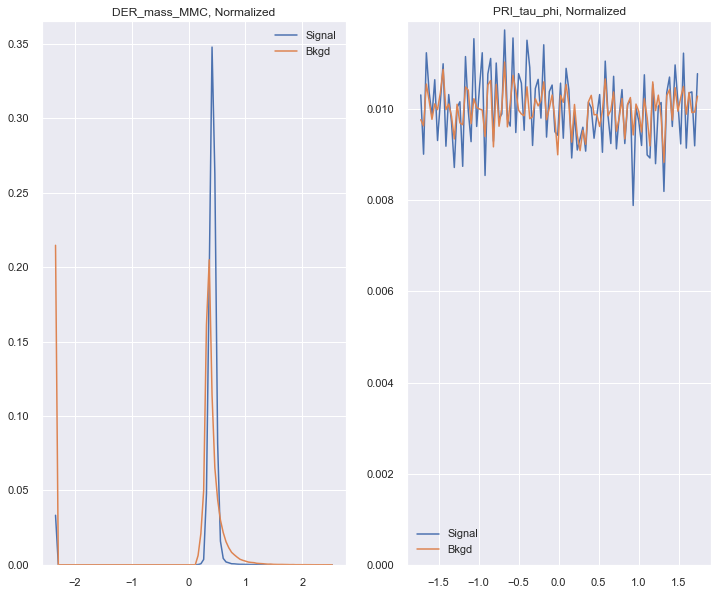

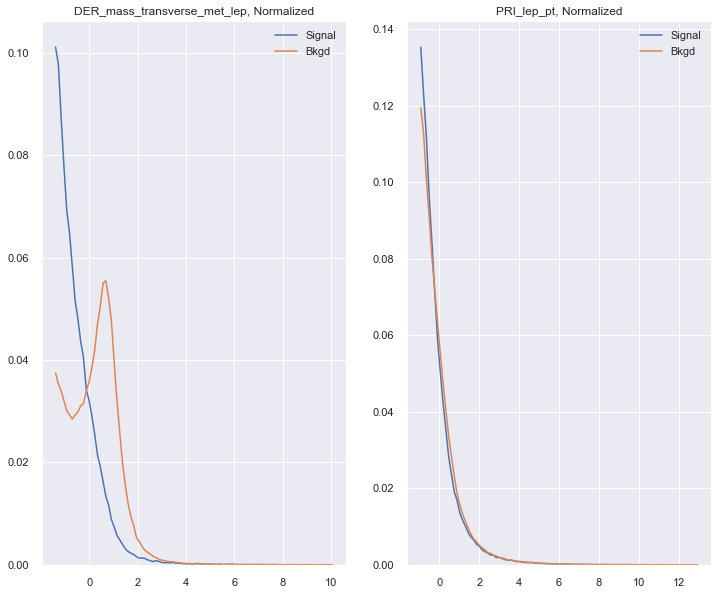

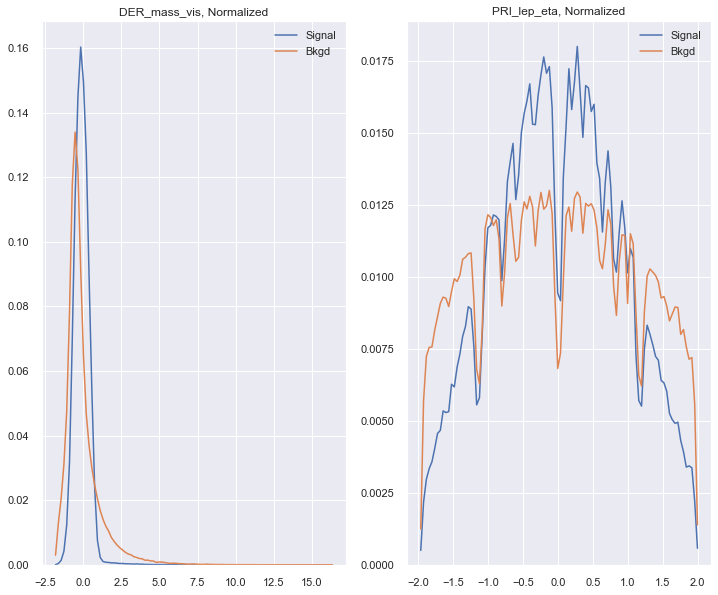

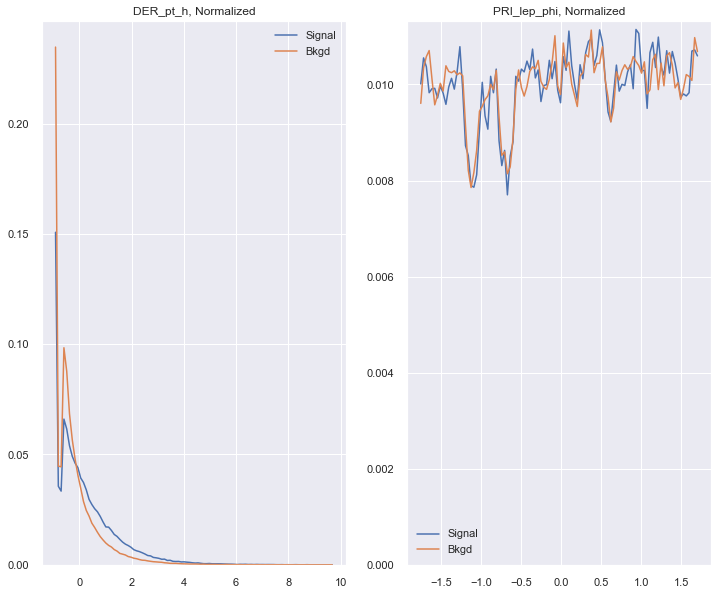

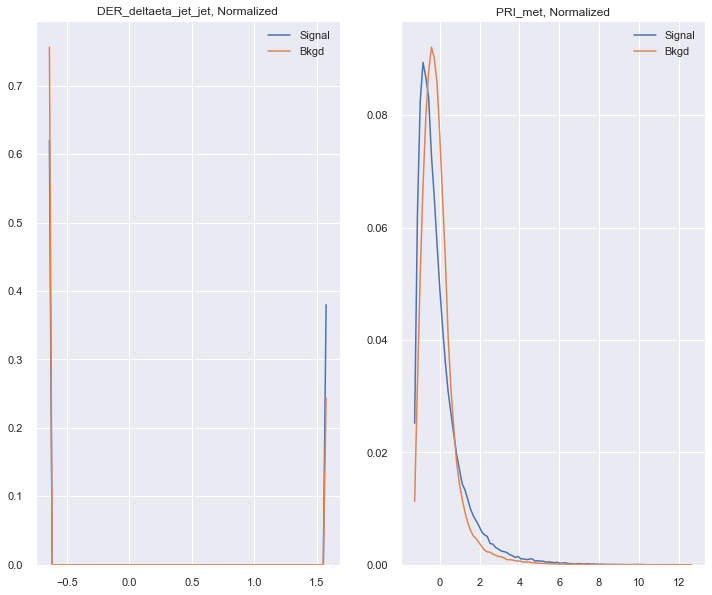

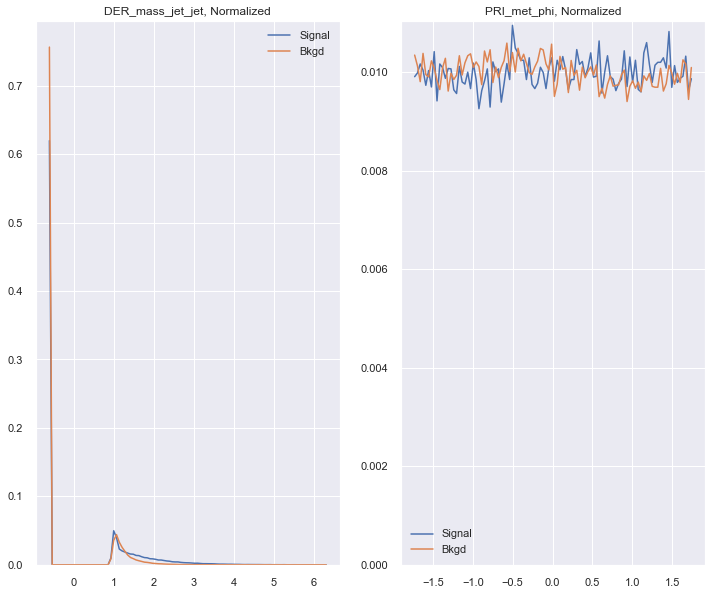

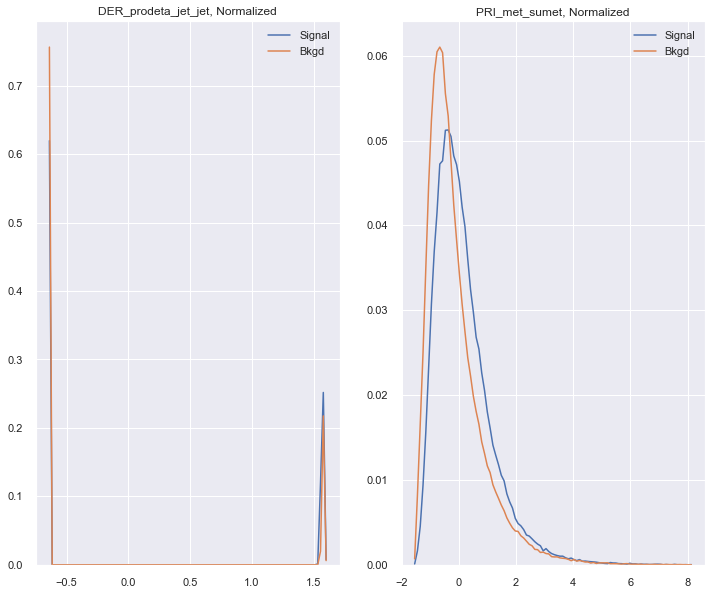

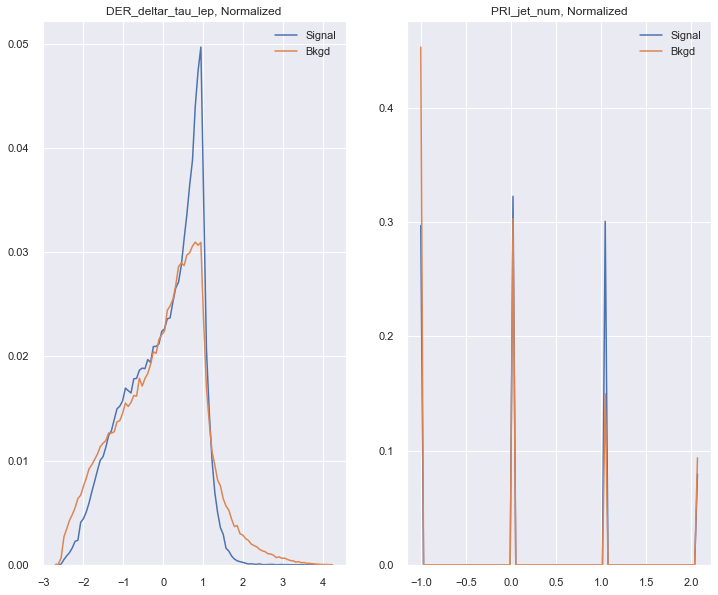

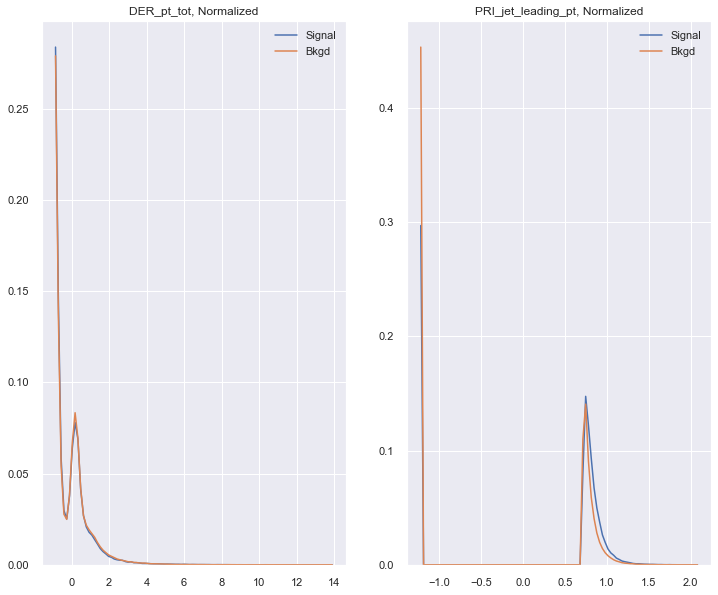

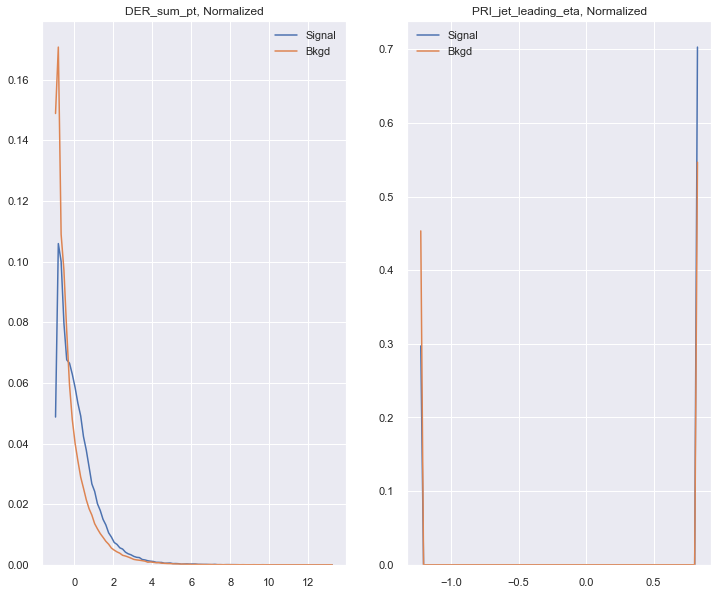

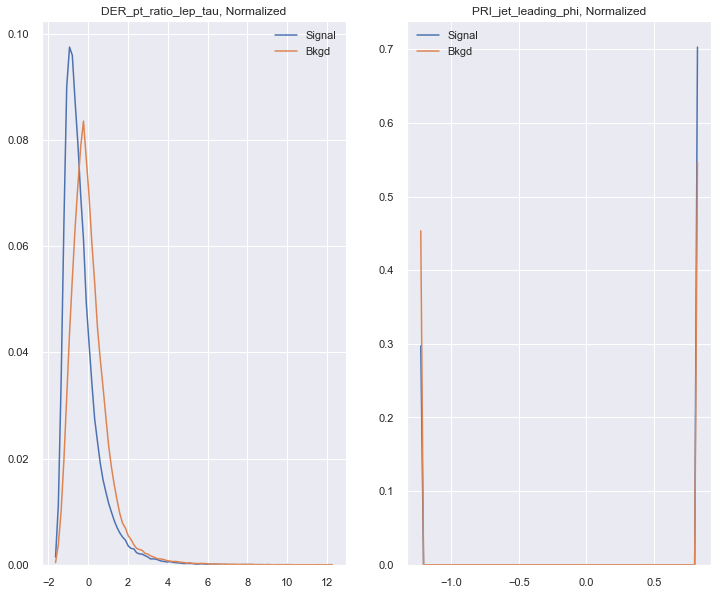

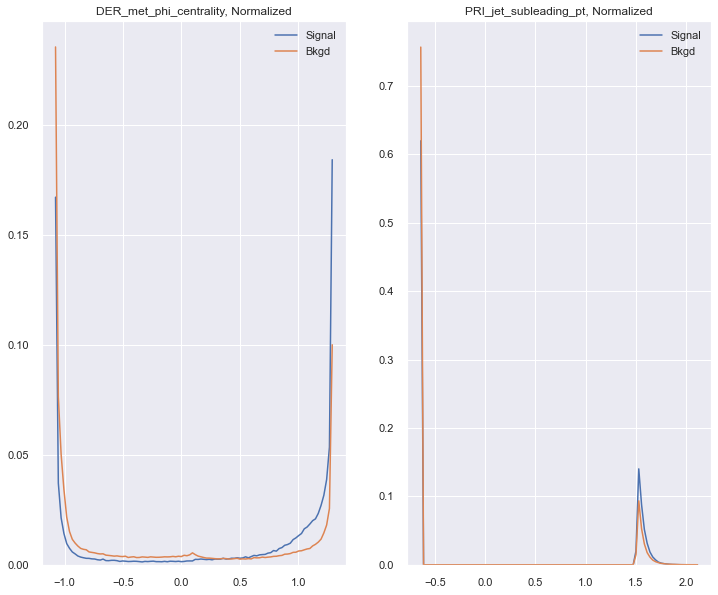

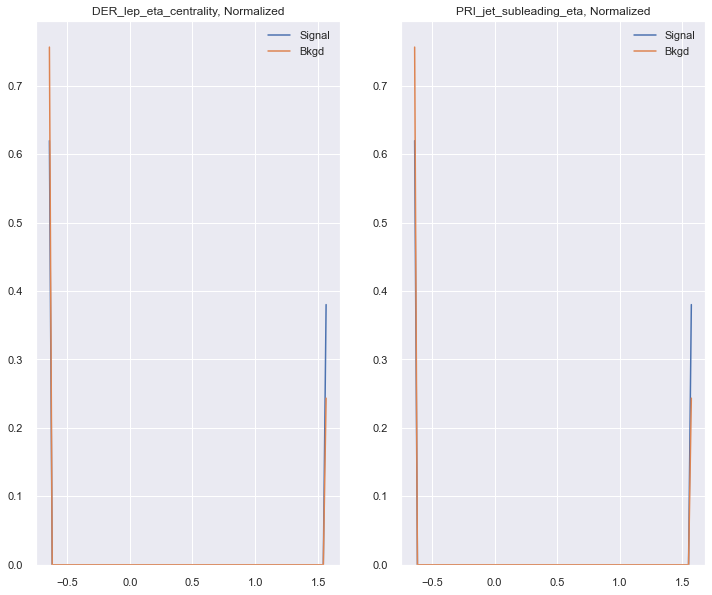

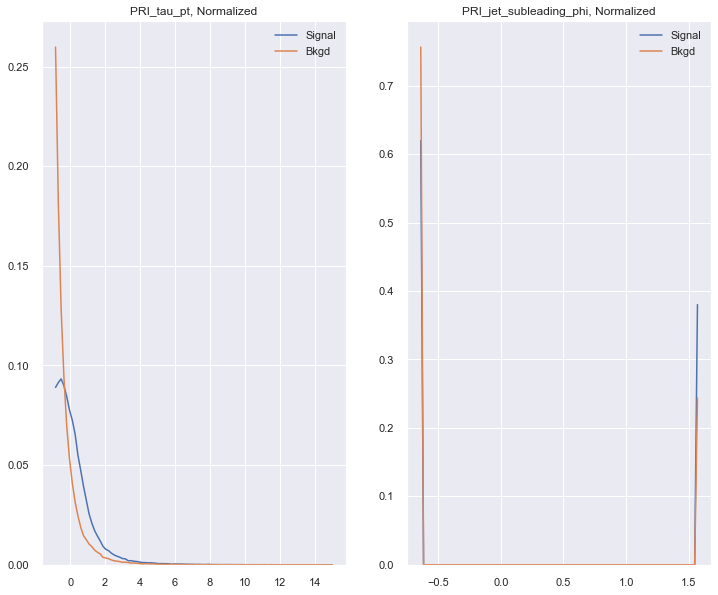

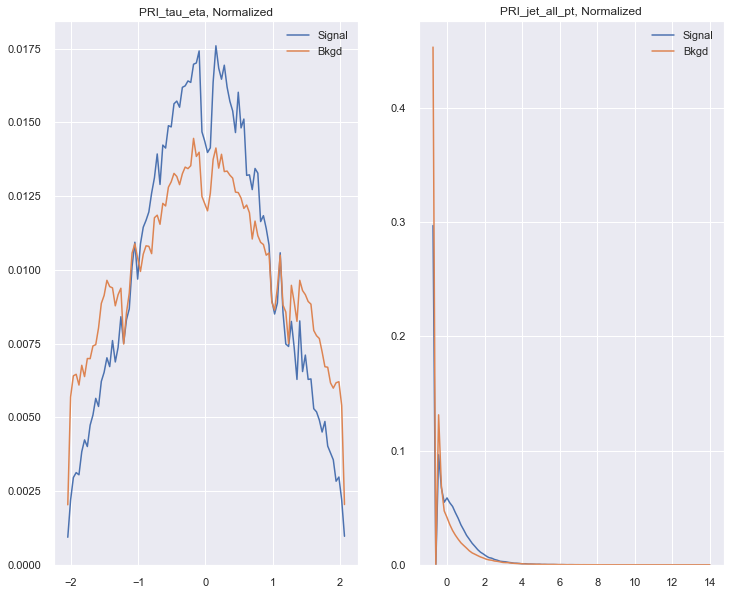

In [4]:
def getRange(sig, bkg):
    ret = np.zeros(2)
    amin = np.min(sig)
    ret[0] = amin
    if amin <-998:
        ret[0] = 0
    vals, bins = np.histogram(sig,bins=100)
    vals2, bins2 = np.histogram(bkg,bins=100)

    ret[1] = np.maximum(np.max(sig),np.max(bkg))

    idx = 0
    for val in vals:
        if val > 2:
            ret[1] = bins[idx+1]
        if vals2[idx] > 2:
            ret[1] = bins2[idx+1]
        idx += 1
        
    if ret[1] < ret[0]:
        ret[1] = np.maximum(np.max(sig),np.max(bkg))
    
    if np.abs(1.0-ret[1])<0.1:
        ret[1] = 1.0
    
    return ret

def plotHisto(sig,bkg,label,ax, doNorm=True, s_weight=None, b_weight=None):
    trange = getRange(sig,bkg)
    
    sweight = None
    bweight = None
    if doNorm == True:
        sweight = s_weight
        bweight = b_weight
    
    sVals, edges = np.histogram(sig,bins=100,range=trange,weights=sweight)
    bVals, edges = np.histogram(bkg,bins=100,range=trange,weights=bweight)
    xvals = np.linspace(trange[0],trange[1],100)
    
    if doNorm:
        ax.plot(xvals,sVals/np.sum(sVals),label="Signal")
        ax.plot(xvals,bVals/np.sum(bVals),label="Bkgd")
        ax.set_title("{}, Normalized".format(label))
    else:
        ax.plot(xvals,sVals,label="Signal")
        ax.plot(xvals,bVals,label="Bkgd")
        ax.set_title("{}, Unnormalized".format(label))
    ax.set_ylim(bottom=0)
    ax.legend()


for idx in range(int(colNames.size / 2)):
    idx2 = int(colNames.size / 2)+idx
    
    fig, axs = plt.subplots(1,2, figsize=(12,10))
    plotHisto(Xplot[sSelector,idx],Xplot[bSelector,idx],colNames[idx],axs[0])
    plotHisto(Xplot[sSelector,idx2],Xplot[bSelector,idx2],colNames[idx2],axs[1])

    plt.show()

# Build a neural network

Our goal is to correctly classify signal and background events.  There are many ways to approach this, but for now we'll focus on neural networks.  For this exercise, we'll get started by using the Multilayer Perceptron class from `scikit-learn`.  This has become a very nice implementation that can create rather deep networks.  The major downside is that it does not have GPU or TPU support.

For our first step, let's consider that we have 30 features.  This is a relatively large space with many potential correlations, so we'll want to try for a relatively large network.  Let's start off by creating a network with two hidden layers with 30 nodes (neurons) and limit to 50 training cycles.  This will give us a first benchmark for our problem.

In [5]:
clf = MLPClassifier(hidden_layer_sizes=(30,30),
                    random_state=1,verbose=True,max_iter=50)

clf.fit(Xplot,yt)

Iteration 1, loss = 0.41699108
Iteration 2, loss = 0.38178938
Iteration 3, loss = 0.37505380
Iteration 4, loss = 0.37191775
Iteration 5, loss = 0.36988044
Iteration 6, loss = 0.36837441
Iteration 7, loss = 0.36719951
Iteration 8, loss = 0.36637516
Iteration 9, loss = 0.36577687
Iteration 10, loss = 0.36509558
Iteration 11, loss = 0.36446782
Iteration 12, loss = 0.36409567
Iteration 13, loss = 0.36370427
Iteration 14, loss = 0.36345326
Iteration 15, loss = 0.36306646
Iteration 16, loss = 0.36274687
Iteration 17, loss = 0.36256795
Iteration 18, loss = 0.36237031
Iteration 19, loss = 0.36202725
Iteration 20, loss = 0.36206284
Iteration 21, loss = 0.36175734
Iteration 22, loss = 0.36159018
Iteration 23, loss = 0.36125522
Iteration 24, loss = 0.36141719
Iteration 25, loss = 0.36109384
Iteration 26, loss = 0.36098262
Iteration 27, loss = 0.36077077
Iteration 28, loss = 0.36069020
Iteration 29, loss = 0.36047909
Iteration 30, loss = 0.36047681
Iteration 31, loss = 0.36018732
Iteration 32, los

/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(30, 30), max_iter=50, random_state=1,
              verbose=True)

In [6]:
def plotNNresults(predictions,sSelector,bSelector,weights):
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    plotHisto(predictions[sSelector,0],predictions[bSelector,0],"Neural Nework",
              axs[0],doNorm=False)
    plotHisto(predictions[sSelector,0],predictions[bSelector,0],"Neural Nework",
              axs[1],doNorm=True,b_weight=weights[bSelector],s_weight=weights[sSelector])
    plt.show()
    
    class_names = ['Signal','Background']
    fig, ax = plt.subplots(1,2,figsize=(14,6))
    plt.rcParams.update({'font.size': 22})
    disp = plot_confusion_matrix(clf, Xplot, yt, display_labels=class_names,normalize='true',ax=ax[0])
    ax[0].set_title("Unweighted")
    plt.grid(False)

    disp = plot_confusion_matrix(clf, Xplot, yt, display_labels=class_names,normalize='true',ax=ax[1],sample_weight=weights)
    ax[1].set_title("Weighted")
    plt.grid(False)
    plt.show()

# Now let's plot our NN results

We'll first pull the score (overall accuracy) and then plot the NN output values as well as the confusion matrix.  Note that we get somewhat different results for the cases in which we weight our events.

Unweighted score:  0.8390371428571428
Weighted score:  0.9410455505154737
Prediction array structure:
 [[0.3932006  0.6067994 ]
 [0.10367057 0.89632943]
 [0.19043377 0.80956623]
 [0.0885875  0.9114125 ]
 [0.02977866 0.97022134]
 [0.10581177 0.89418823]
 [0.56347376 0.43652624]
 [0.92129011 0.07870989]
 [0.18052204 0.81947796]
 [0.5354294  0.4645706 ]]


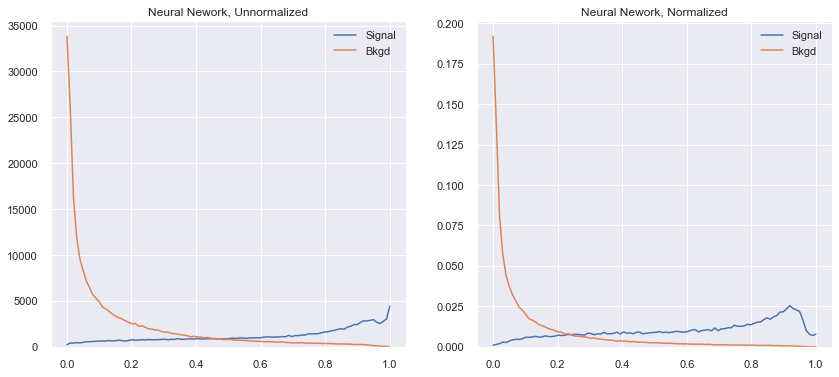

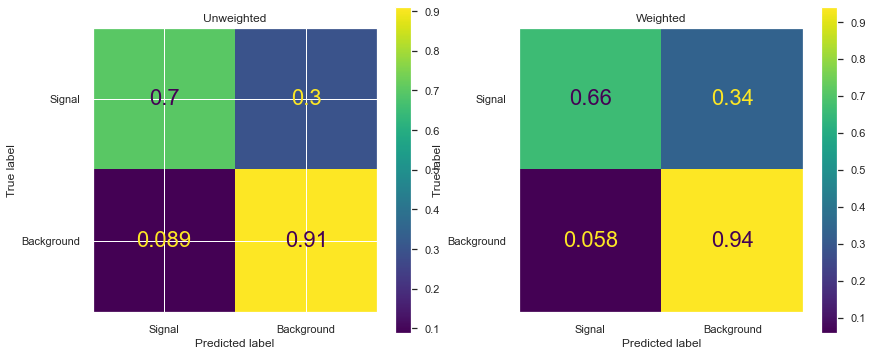

In [7]:
print("Unweighted score: ", clf.score(Xplot,yt))
print("Weighted score: ",clf.score(Xplot,yt,weights))

predictions = clf.predict_proba(Xplot)

print("Prediction array structure:\n",predictions[:10])

plotNNresults(predictions,sSelector,bSelector,weights) 


# Finally, let's check to see how we did for our challenge

The challenge was "judged" based on the Approximate Mean Significance (AMS) score.  Let's just quickly check how we did on our training data.  This is an over-estimate because we trained on this data, but it will give us an idea of how we did!  Remember the best work in the Higgs ML challenge achieved an AMS score of ~ 3.80.

In [8]:
def ams(s,b):
    from math import sqrt,log
    if b==0:
        return 0
    
    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))

def plotAMS(X,y,weights):
    # order them 
    sSelector = np.array(y == 0)
    bSelector = np.array(y == 1)
    
    permute = X.argsort()
    sSelector = sSelector[permute]
    bSelector = bSelector[permute]
    X = X[permute]
    weights = weights[permute]

    # pick out only the signal values
    sVals = X[sSelector]
    sigW = weights[sSelector]

    # pick out only the background values
    bVals = X[bSelector]
    bkgW = weights[bSelector]

    # make arrays
    xvals = np.linspace(0,1,100)
    amsV = np.linspace(0,1,100)
    bkgFrac = np.linspace(0,1,100)
    aIdx = 0

    # We are going to organize by background rejection fraction,
    # so we need to find those values
    for xx in xvals:
        idxS = bisect.bisect_left(sVals,xx)
        idxB = bisect.bisect_left(bVals,xx)
        amsV[aIdx] = ams(np.sum(sigW[idxS:]),np.sum(bkgW[idxB:]))
        bkgFrac[aIdx] = 1-np.sum(bkgW[idxB:])/np.sum(bkgW)
        aIdx += 1

    permute = bkgFrac.argsort()
    bkgFrac = bkgFrac[permute]
    amsV = amsV[permute]

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(bkgFrac*100,amsV)
    ax.set_xlabel("Background rejection (%)")
    ax.set_ylabel("AMS Score")
    plt.show()
    print("Maximum AMS Value: ",np.max(amsV))

Shape:
 (468239, 35) 



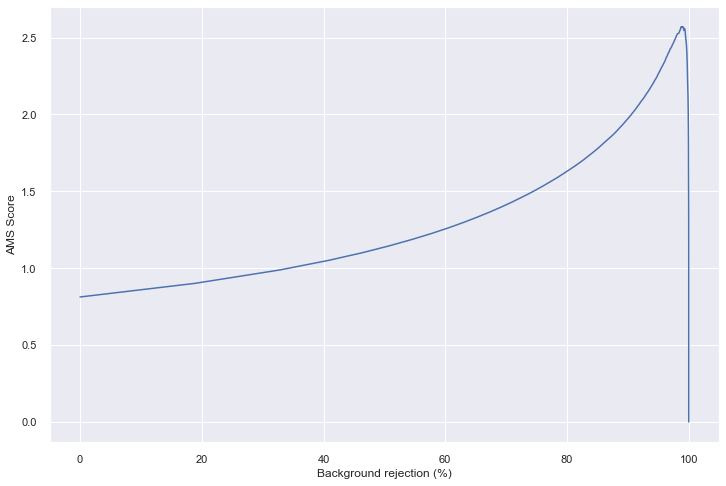

Maximum AMS Value:  2.5709074630595357


In [9]:
# read the first last ~468k samples
datasetVal=pd.read_csv('higgs-boson/atlas-higgs-challenge-2014-v2.csv',skiprows = range(1, 350000))

# shape
print("Shape:\n",datasetVal.shape, "\n")

# Make a new dataframe without some of the features
Xval = datasetVal.drop([ 'Label','EventId','Weight','KaggleSet','KaggleWeight'],axis=1,inplace=False)
weightsVal = datasetVal['Weight'].values

# Perform standard scaling!
XplotV = scaler.transform(Xval.values)  

# Two forms of the labels
y = pd.get_dummies(datasetVal.Label)
yVal = y.values[:,0]

# Evaluate our new data with the NN
predictions = clf.predict_proba(XplotV)

# Plot the AMS scores
plotAMS(predictions[:,0],yVal,weightsVal)

# Feature Dropout Test

Here let's try dropping one feature at a time to see how the training accuracy depends on each variable.  I'm setting the max iterations to 25, which isn't quite the same as what was done in the previous test.  However, it will speed things up and the loss is not so dissimilar at 50 iterations.

In [10]:
drop_scores = np.zeros(colNames.size)
drop_scoresW = np.zeros(colNames.size)
drop_loss = np.zeros(colNames.size)

for idx in range(colNames.size):
    print("\n Dropped Var: ", colNames[idx])
    
    clf = MLPClassifier(hidden_layer_sizes=(30,30),
                    random_state=1,verbose=False,max_iter=25)
    
    xSmall = np.delete(Xplot,idx,1)
    clf.fit(xSmall,yt)
    drop_scores[idx] = clf.score(xSmall,yt)
    drop_scoresW[idx] = clf.score(xSmall,yt,weights)
    drop_loss[idx] = clf.loss_
    print("Unweighted score: ", drop_scores[idx])
    print("Weighted score: ", drop_scoresW[idx])
    print("Loss: ", clf.loss_)


 Dropped Var:  DER_mass_MMC


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8368342857142858
Weighted score:  0.9346511688550005
Loss:  0.36251457142305404

 Dropped Var:  DER_mass_transverse_met_lep


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8334457142857142
Weighted score:  0.9342041650554103
Loss:  0.36826044406182334

 Dropped Var:  DER_mass_vis


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8359171428571428
Weighted score:  0.9360459031387887
Loss:  0.3659366662714651

 Dropped Var:  DER_pt_h


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8369571428571428
Weighted score:  0.9348178690735878
Loss:  0.3625311179930161

 Dropped Var:  DER_deltaeta_jet_jet


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8377057142857143
Weighted score:  0.9360418371451357
Loss:  0.3616873901090427

 Dropped Var:  DER_mass_jet_jet


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8348371428571428
Weighted score:  0.9341154439596571
Loss:  0.3683364022639315

 Dropped Var:  DER_prodeta_jet_jet


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.83716
Weighted score:  0.9339001979109265
Loss:  0.36213397359388144

 Dropped Var:  DER_deltar_tau_lep


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8361714285714286
Weighted score:  0.9357438092788953
Loss:  0.3670112639916137

 Dropped Var:  DER_pt_tot


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8359571428571428
Weighted score:  0.9351294002915532
Loss:  0.3648220401529229

 Dropped Var:  DER_sum_pt


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8374685714285715
Weighted score:  0.9357854990072927
Loss:  0.3622377843322253

 Dropped Var:  DER_pt_ratio_lep_tau


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8374228571428571
Weighted score:  0.9362905791832604
Loss:  0.36262505972700054

 Dropped Var:  DER_met_phi_centrality


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8355542857142857
Weighted score:  0.9343403223669516
Loss:  0.36457187581677575

 Dropped Var:  DER_lep_eta_centrality


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8366342857142857
Weighted score:  0.9343772599354356
Loss:  0.3625758575649651

 Dropped Var:  PRI_tau_pt


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8372228571428572
Weighted score:  0.9366778443108513
Loss:  0.36255571855576346

 Dropped Var:  PRI_tau_eta


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8365314285714286
Weighted score:  0.9376891818589995
Loss:  0.3628636487854341

 Dropped Var:  PRI_tau_phi


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8372685714285715
Weighted score:  0.9359572339340775
Loss:  0.3621702391816835

 Dropped Var:  PRI_lep_pt


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8365542857142857
Weighted score:  0.9343490105505656
Loss:  0.36298530925895717

 Dropped Var:  PRI_lep_eta


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8364
Weighted score:  0.9370910293361359
Loss:  0.36346853988903255

 Dropped Var:  PRI_lep_phi


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8368771428571429
Weighted score:  0.9364899955512499
Loss:  0.36183455878259535

 Dropped Var:  PRI_met


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8358714285714286
Weighted score:  0.9342850055145784
Loss:  0.3654024975176319

 Dropped Var:  PRI_met_phi


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8372028571428571
Weighted score:  0.936523213708167
Loss:  0.36220020423423094

 Dropped Var:  PRI_met_sumet


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8359885714285714
Weighted score:  0.9363973888959439
Loss:  0.36282591984259166

 Dropped Var:  PRI_jet_num


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8373142857142857
Weighted score:  0.9369323463698993
Loss:  0.36241105444751404

 Dropped Var:  PRI_jet_leading_pt


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8375942857142857
Weighted score:  0.9351446669684947
Loss:  0.36180724861999186

 Dropped Var:  PRI_jet_leading_eta


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8376371428571429
Weighted score:  0.9357772137856012
Loss:  0.3612133971002504

 Dropped Var:  PRI_jet_leading_phi


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8378514285714286
Weighted score:  0.9370318927179517
Loss:  0.36109151700028375

 Dropped Var:  PRI_jet_subleading_pt


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8376028571428571
Weighted score:  0.9366721582633563
Loss:  0.36156442598334626

 Dropped Var:  PRI_jet_subleading_eta


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8377685714285714
Weighted score:  0.9366704911297599
Loss:  0.36165239026381013

 Dropped Var:  PRI_jet_subleading_phi


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.83768
Weighted score:  0.9371543360204768
Loss:  0.3614988469443406

 Dropped Var:  PRI_jet_all_pt


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8372457142857143
Weighted score:  0.9361314043115633
Loss:  0.3614720673490585


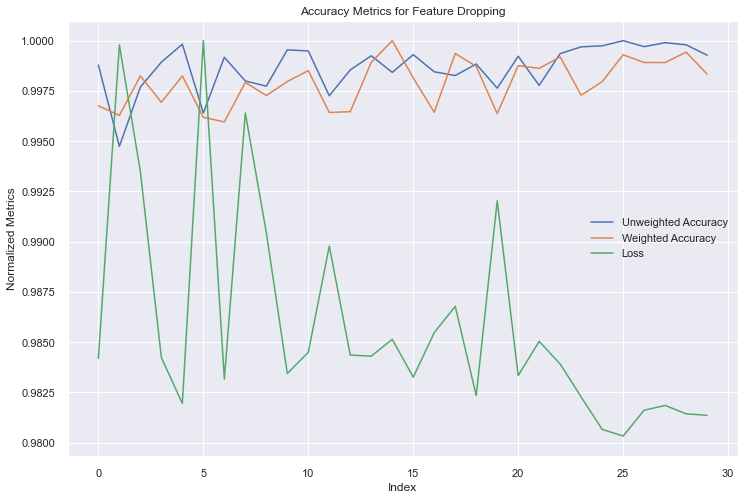

In [11]:
# Make a plot of our results

def optimizationPlot(scores, scoresW, loss, xrange, title, doLog=False):
    # Normalize to max so we can view more easily
    scores = scores * 1.0/np.max(scores)
    scoresW = scoresW * 1.0/np.max(scoresW)
    loss = loss * 1.0/np.max(loss)

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(xrange,scores,label='Unweighted Accuracy')
    ax.plot(xrange,scoresW,label='Weighted Accuracy')
    ax.plot(xrange,loss,label='Loss')
    ax.set_title("Accuracy Metrics for {}".format(title))
    ax.set_xlabel("Index")
    ax.set_ylabel("Normalized Metrics")
    plt.legend()
    if doLog:
        ax.set_xscale('log')
    plt.show()
    
optimizationPlot(drop_scores, drop_scoresW, drop_loss,range(colNames.size), "Feature Dropping")

# Now let's scan the learning rate

The default learning rate is 0.001 and it's not clear if that is appropriate for our case.  We should check this!  To do so we will scan over several orders of magnitude from 1E-4 to 1E-1.

In [12]:
lr_steps = 10
lr_scores = np.zeros(lr_steps)
lr_scoresW = np.zeros(lr_steps)
lr_loss = np.zeros(lr_steps)

idx = 0
for lr in np.logspace(-4,-1,lr_steps):
    print("\n Learning Rate: ", lr)
    clf = MLPClassifier(hidden_layer_sizes=(30,30),random_state=1,
                        verbose=False,max_iter=25,learning_rate_init=lr)
    clf.fit(Xplot,yt)
    lr_scores[idx] = clf.score(Xplot,yt)
    lr_scoresW[idx] = clf.score(Xplot,yt,weights)
    lr_loss[idx] = clf.loss_
    print("Unweighted score: ", lr_scores[idx])
    print("Weighted score: ", lr_scoresW[idx])
    print("Loss: ",clf.loss_)
    idx += 1


 Learning Rate:  0.0001


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8324457142857142
Weighted score:  0.9282225688913328
Loss:  0.3723830522098173

 Learning Rate:  0.00021544346900318845


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8348714285714286
Weighted score:  0.9295119522462061
Loss:  0.366437524547421

 Learning Rate:  0.00046415888336127773


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8367742857142857
Weighted score:  0.9261489208802256
Loss:  0.36276558143585796

 Learning Rate:  0.001


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.83742
Weighted score:  0.9199808410469016
Loss:  0.3610938398413442

 Learning Rate:  0.002154434690031882


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8363028571428571
Weighted score:  0.9154379095443506
Loss:  0.36079545454322565

 Learning Rate:  0.004641588833612777


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.83736
Weighted score:  0.9171215473749941
Loss:  0.36244643433417506

 Learning Rate:  0.01


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8360942857142857
Weighted score:  0.9148019786861292
Loss:  0.36589711502042277

 Learning Rate:  0.021544346900318822


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8326257142857143
Weighted score:  0.9120032019591581
Loss:  0.373638665412621

 Learning Rate:  0.046415888336127774


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.83246
Weighted score:  0.9247279795535038
Loss:  0.383065449858655

 Learning Rate:  0.1
Unweighted score:  0.8141514285714285
Weighted score:  0.8899375032470097
Loss:  0.40095068853999843


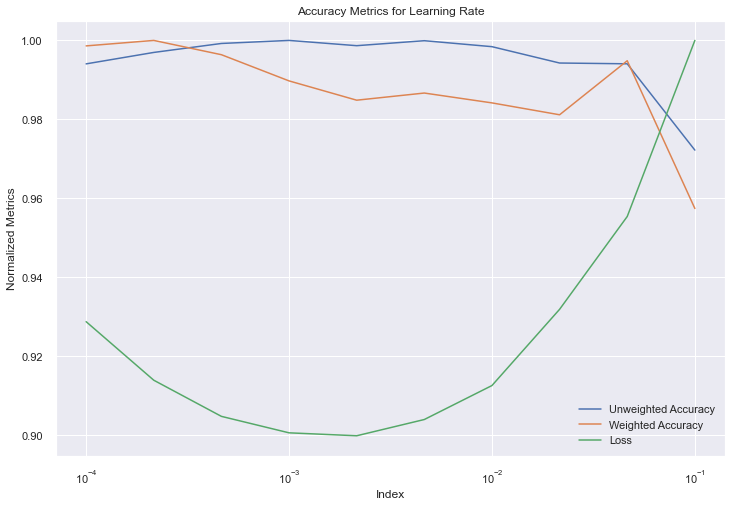

In [17]:
# Plot it!
optimizationPlot(lr_scores, lr_scoresW, lr_loss,np.logspace(-4,-1,lr_steps), "Learning Rate",doLog=True)

# And now let's scan the L2 regularization strength

The `scikit-learn` Multilayer Perceptron includes L2 regularization by default with a regularization strength of 1E-4.  Just as we saw with the learning rate, it's not clear if this is optimal for our problem so we should scan this space.  Let's try going from 1E-6 to 1E-2.

In [18]:
reg_steps = 10
reg_scores = np.zeros(reg_steps)
reg_scoresW = np.zeros(reg_steps)
reg_loss = np.zeros(reg_steps)

idx = 0
for reg in np.logspace(-6,-2,reg_steps):
    print("\n Regularization Strength: ", reg)
    clf = MLPClassifier(hidden_layer_sizes=(30,30),random_state=1,
                        verbose=False,max_iter=25,alpha=reg)
    clf.fit(Xplot,yt)
    reg_scores[idx] = clf.score(Xplot,yt)
    reg_scoresW[idx] = clf.score(Xplot,yt,weights)
    reg_loss[idx] = clf.loss_
    print("Unweighted score: ", reg_scores[idx])
    print("Weighted score: ", reg_scoresW[idx])
    print("Loss: ",clf.loss_)
    idx += 1


 Regularization Strength:  1e-06


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8372028571428571
Weighted score:  0.9196833664381586
Loss:  0.3611644023729013

 Regularization Strength:  2.782559402207126e-06


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8373085714285714
Weighted score:  0.9230392402469466
Loss:  0.3611039096669035

 Regularization Strength:  7.742636826811277e-06


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8374514285714286
Weighted score:  0.9204037716919103
Loss:  0.3609324334691054

 Regularization Strength:  2.1544346900318823e-05


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8371171428571429
Weighted score:  0.9204362154183184
Loss:  0.36126348170289824

 Regularization Strength:  5.994842503189409e-05


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8372057142857143
Weighted score:  0.9194631270175653
Loss:  0.3612444890458512

 Regularization Strength:  0.0001668100537200059


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8369085714285714
Weighted score:  0.9197624708860898
Loss:  0.3609201296547745

 Regularization Strength:  0.00046415888336127773


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8372971428571429
Weighted score:  0.9207586505286544
Loss:  0.36152636273871486

 Regularization Strength:  0.0012915496650148827


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8372971428571429
Weighted score:  0.9211717358085084
Loss:  0.36177996885639246

 Regularization Strength:  0.003593813663804626


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.83692
Weighted score:  0.9203466002921382
Loss:  0.3624552639011965

 Regularization Strength:  0.01


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8367971428571429
Weighted score:  0.92064157422185
Loss:  0.364384243042288


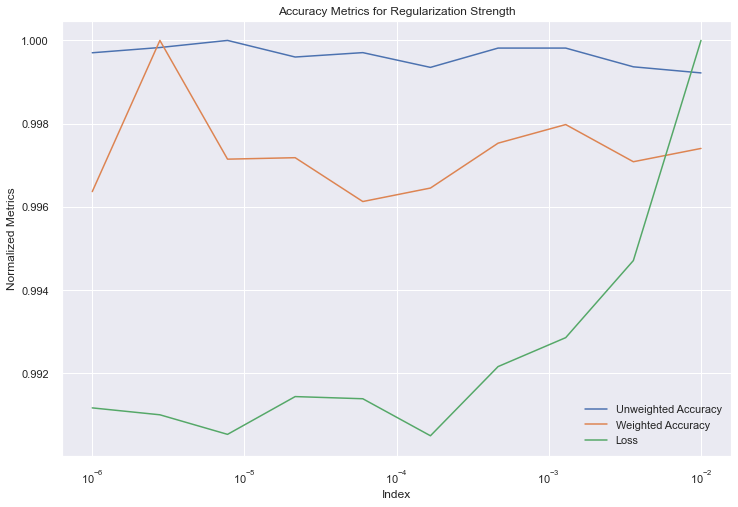

In [19]:
# Plot it!
optimizationPlot(reg_scores, reg_scoresW, reg_loss,np.logspace(-6,-2,reg_steps), 
                 "Regularization Strength",doLog=True)

# One last variable: mini-batch size

As the MLP performs stochastic gradient descent, the batch size is set to `batch_size=min(200, n_samples)` which means 200 for our case.  We should explore other options in the range of 50-5000.  Note that the default for `scikit-learn`'s MLP is to randomly shuffle the data sample between epochs (training iterations).  This is important because it forces the training cycles to see different batches and, thus, be a bit more independent.

In [33]:
bat_steps = 10
bat_scores = np.zeros(bat_steps)
bat_scoresW = np.zeros(bat_steps)
bat_loss = np.zeros(bat_steps)
      
idx = 0
for bat in np.arange(50,1000,int((1000-50)/bat_steps)):
    print("\n Batch Size: ", bat)
    clf = MLPClassifier(hidden_layer_sizes=(30,30),random_state=1,
                        verbose=False,max_iter=25,batch_size = bat)
    clf.fit(Xplot,yt)
    bat_scores[idx] = clf.score(Xplot,yt)
    bat_scoresW[idx] = clf.score(Xplot,yt,weights)
    bat_loss[idx] = clf.loss_
    print("Unweighted score: ", bat_scores[idx])
    print("Weighted score: ", bat_scoresW[idx])
    print("Loss: ",clf.loss_)
    idx += 1


 Batch Size:  50


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8342628571428572
Weighted score:  0.9116252580689933
Loss:  0.3609197193509527

 Batch Size:  145


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8372828571428571
Weighted score:  0.9194460297581667
Loss:  0.3607919222267756

 Batch Size:  240


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8364142857142857
Weighted score:  0.9172423048054592
Loss:  0.36137200166467826

 Batch Size:  335


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8374771428571428
Weighted score:  0.9285566836921612
Loss:  0.36147295010273917

 Batch Size:  430


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8379742857142857
Weighted score:  0.9330910977855211
Loss:  0.3614958571330797

 Batch Size:  525


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8374971428571428
Weighted score:  0.9339305780194715
Loss:  0.36234260477341823

 Batch Size:  620


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8369514285714286
Weighted score:  0.9336687501434247
Loss:  0.36266028118690347

 Batch Size:  715


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8368285714285715
Weighted score:  0.9309611522336664
Loss:  0.3628856729196573

 Batch Size:  810


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8366742857142857
Weighted score:  0.929074811262718
Loss:  0.36300336970386166

 Batch Size:  905


/Users/wfisher/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Unweighted score:  0.8363114285714286
Weighted score:  0.9253107170807149
Loss:  0.36317051762897873


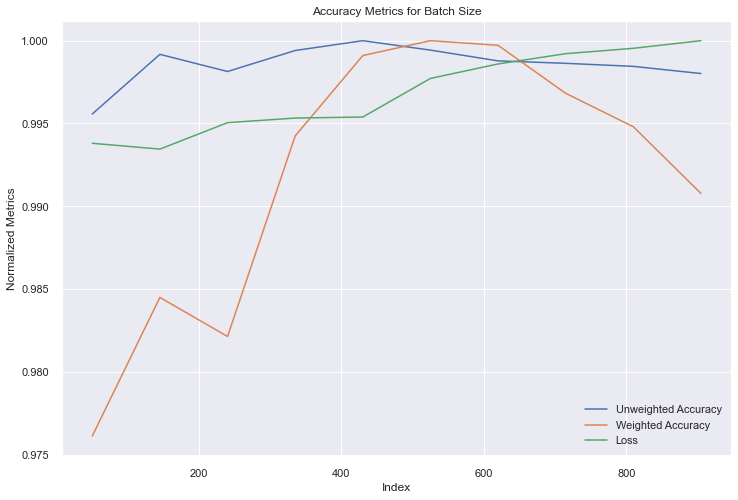

In [34]:
# Plot it!
optimizationPlot(bat_scores, bat_scoresW, bat_loss,np.arange(50,1000,int((1000-50)/bat_steps)), "Batch Size")